# Catcher Pitch Framing

See this paper for a "hierarchical bayesian" approach:https://arxiv.org/abs/1704.00823

See this DataRobot blog post for a ML approach (really just logistic regression): https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-1

Or, the improved DataRobot model: https://blog.datarobot.com/catcher-pitch-framing-using-machine-learning-part-two



In [8]:
import csv
import requests
from bs4 import BeautifulSoup, Comment
bbref_addr = 'https://www.baseball-reference.com'

from pybaseball import statcast

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from pygam import LogisticGAM

## Data and Model

The goal of this study is to build a statistical model to estimate each umpire's probability of calling a strike (adjusting for pitch participants, pitch location and contextual information like the count).  Using this model we can estimate each catcher's effect on an umpire's chance of calling a strike.  We then translate thes estimated effects into average runs saved across a season.

The approach we take to esimate the catcher effect is to use an iterative method to first distribute credit for a called strike among the batter, catcher, pitcher and umpire.  We will fit a statistical model of the called strike probability that accounts for the above factors.  Armed with such a model, we then estimate the predicted called strike probability with and without the catcher.  The difference in these probabilities reflects the catcher's apparent framing effect on that pitch.  Finally, we estimate the impact of framing by weighting these effects by the value of "stealing a strike" and summing over all pitches caught by a catcher.

Before beginning, let us introduce some notation.  

 - For a given taken pitch, let $y=1$ if it is called a strike and let $y = 0$ if it is called a ball.
 
 - Let __b__, __ca__, __co__, __p__ and __u__ be indices corresponding to the batter, catcher, count, pitcher and umpire for that pitch.
 
 - Let $x$ and $z$ be the horizontal and vertical coordinates of the pitch as it crosses the front of home plate, respectively 
 
 - To accomodate a separate model for each umpire $u$ we introduce vectors $\Theta^{u, B}$, $\Theta^{u, CA}$, $\Theta^{u, CO}$ and $\Theta^{u, P}$ to hold the _partial_ effect of each batter, catcher, count and pitcher, respectively, on umpire _u_'s likelihood to call a strike. 
 
 - For each umpire _u_, we introduce a function of pitch location $f^u(x, z)$
 
Then, at a high level, we model the log-odds as:

\begin{equation}
\log \left( \frac{P(y = 1)}{P(y = 0)} \right) = \Theta^{u, B}_b + \Theta^{u, CA}_{ca} + \Theta^{u, CO}_{co} + \Theta^{u, P}_p + f^u(x, z)
\end{equation}

All of the models are fit in a hierarchical Bayesian framework, which provides natural uncertainty quantification for our framing estimates (this quantification is is vital considering the fact that several teams are making framing-based roster decisions).

#### Download the Pitch-by-Pitch Data (if you haven't already)

In [ ]:
# pitch-by-pitch data
# data2010 = statcast(start_dt='2010-04-04', end_dt='2010-10-03')
# data2010.to_csv("../data/pitch_data_2010.csv", index=False)

# data2011 = statcast(start_dt='2011-03-31', end_dt='2011-09-28')
# data2011.to_csv("../data/pitch_data_2011.csv", index=False)

# data2012 = statcast(start_dt='2012-03-28', end_dt='2012-10-03')
# data2012.to_csv("../data/pitch_data_2012.csv", index=False)

# data2013 = statcast(start_dt='2013-03-31', end_dt='2013-09-30')
# data2013.to_csv("../data/pitch_data_2013.csv", index=False)

# data2014 = statcast(start_dt='2014-03-22', end_dt='2014-09-28')
# data2014.to_csv("../data/pitch_data_2014.csv", index=False)

# data2015 = statcast(start_dt='2015-04-05', end_dt='2015-10-04')
# data2015.to_csv("../data/pitch_data_2015.csv", index=False)

# data2016 = statcast(start_dt='2016-04-03', end_dt='2016-10-02')
# data2016.to_csv("../data/pitch_data_2016.csv", index=False)

# data2017 = statcast(start_dt='2017-04-02', end_dt='2017-10-01')
# data2017.to_csv("../data/pitch_data_2017.csv", index=False)

# data2018 = statcast(start_dt='2018-03-29', end_dt='2018-10-01')
# data2018.to_csv("../data/pitch_data_2018.csv", index=False)

# data2019 = statcast(start_dt='2019-03-20', end_dt='2019-08-31')
# data2019.to_csv("../data/pitch_data_2019.csv", index=False)

#### Scrape the Homeplate Umpire Data (if you haven't already)

In [9]:
def scrape_hp_umps(year=2015):
    
    schedule_page = requests.get(f"{bbref_addr}/leagues/MLB/{year}-schedule.shtml")
    soup = BeautifulSoup(schedule_page.content, 'html.parser')
    
    games_list = soup.find_all("p", attrs={"game"})
    games_list_href = [x.find_all("a", href=True)[-1]['href'] for x in games_list]
    
    games_list_href = [x for x in games_list_href if x.startswith('/boxes')]
        
    hp_umpire_dict = {}
    for i, game in enumerate(games_list_href):

        if i % 100 == 0:
            print(f"Game {i}")

        # get the id for the game
        game_id = game.split('/')[-1][:-7]

        # build the url for the game
        game_addr = bbref_addr + game
        
        # scrape the webpage for the game
        game_page = requests.get(game_addr)
        soup = BeautifulSoup(game_page.content, 'html.parser')

        # the umpires are stashed in a comments section
        comments = soup.find_all(string=lambda text: isinstance(text, Comment))
        ump_string = [x for x in comments if 'Umpires' in x][0]
        ump_string = ump_string.strip()
        ump_string = ump_string.replace(',', '')

        # extract the HP umpire
        ump_list = ump_string.split()
        hp_idx = ump_list.index('HP')
        first_name = ump_list[hp_idx+2]
        last_name = ump_list[hp_idx+3]

        hp_umpire_dict[game_id] = first_name + ' ' + last_name
        
    w = csv.writer(open(f"../data/hp_umpires_{year}.csv", "w"))
    for key, val in hp_umpire_dict.items():
        w.writerow([key, val])
        
for year in [2019]:
    print("==================================")
    print(f"getting data for {year} season...")
    print("==================================")
    scrape_hp_umps(year)
    print()

getting data for 2019 season...
Game 0


IndexError: list index out of range

### Statcast Data

We collected all pitch data using the pybaseball python module that allows for easy scraping of websites such as Baseball Savant, baseball-reference.com, etc.

Although we are mainly interested in studying framing effects in the 2018 season, we collected all statcast data from the 2015 to 2019 regular seasons.  We use the data from 2015-17  to select the function of pitch location $f^u(x, z)$.  We then fit the model using the 2015 data and assess the model's predictive performance using data from 2015.

### Function to Pre-process the Data

In [10]:
# import the data for calendar year
def get_pitch_data(year):
    
    print("===================================================")
    print(f"Gathering data for {year} season")
    print("===================================================")
    print()
    
    # import the full pitch-by-pitch dataset 
    pitch_data_df = pd.read_csv(f"../data/pitch_data_{year}.csv")
    total_num_pitches = len(pitch_data_df)
    
    print(f"Number of total pitches in {year} data: {total_num_pitches}")
    print()

    # just keep the balls and called strikes
    pitch_taken = ['ball', 'called_strike']
    pitches_taken_df = pitch_data_df[pitch_data_df['description'].isin(pitch_taken)]
    num_pitches_taken = len(pitches_taken_df)

    print(f"Number of pitches taken: {num_pitches_taken}")
    print(f"Percentage of pitches taken: {round((num_pitches_taken / total_num_pitches) * 100., 2)}")
    print()

    # compute the number/percentage of taken strikes
    strikes_taken_df = pitches_taken_df[pitches_taken_df['description'] == 'called_strike']
    num_strikes_taken = len(strikes_taken_df)

    print(f"Number of strikes taken: {num_strikes_taken}")
    print(f"Percentage of pitches taken that were called strikes: {round((num_strikes_taken / num_pitches_taken) * 100., 2)}")
    print()
    
    # construct the approximate strike zone
    left_strike_boundary = -0.71
    right_strike_boundary = -left_strike_boundary

    pitches_taken_df['low_strike_boundary'] = pitches_taken_df['sz_bot']
    pitches_taken_df['high_strike_boundary'] = pitches_taken_df['sz_bot'] + pitches_taken_df['sz_top']

    bottom_strike_boundary = pitches_taken_df['low_strike_boundary'].mean()
    top_strike_boundary = pitches_taken_df['high_strike_boundary'].mean()

    print("===================================================")
    print(f"Top boundary of approximate strike zone: {round(top_strike_boundary, 2)}")
    print(f"Bottom boundary of approximate strike zone: {round(bottom_strike_boundary, 2)}")
    print(f"Right boundary of approximate strike zone: {right_strike_boundary}")
    print(f"Left boundary of approximate strike zone: {left_strike_boundary}")
    print("===================================================")
    print()
    
    # restrict ourselves to pitches that were "close enough" (i.e., within one foot of the approximate strike zone)
    pitches_taken_df = pitches_taken_df[
        (pitches_taken_df['plate_x'] >= left_strike_boundary - 1) &\
        (pitches_taken_df['plate_x'] <= right_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] <= top_strike_boundary + 1) &\
        (pitches_taken_df['plate_z'] >= bottom_strike_boundary - 1)
    ]
    num_pitches_in_zone = len(pitches_taken_df)
    
    print(f"Number of pitches within 1 foot of approximate stike zone: {num_pitches_in_zone}")
    print(f"Percentage of pitches within 1 foot of approximate strike zone: {round((num_pitches_in_zone / total_num_pitches) * 100., 2)}")
    print()
    
    # join with HP umpire dataframe (to bring in the ID of the HP umpire)
    team_rename_dict = {'NYY': 'NYA',
                        'NYM': 'NYN', 
                        'TB': 'TBA', 
                        'CHC': 'CHN',
                        'CWS': 'CHA',
                        'KC': 'KCA',
                        'SF': 'SFN',
                        'SD': 'SDN',
                        'LAD': 'LAN',
                        'LAA': 'ANA',
                        'STL': 'SLN',
                        'WSH': 'WAS'}

    def rename_team(x):
        if x in list(team_rename_dict.keys()):
            return team_rename_dict[x]
        else:
            return x
    pitches_taken_df['home_team'] = pitches_taken_df['home_team'].apply(rename_team)
    pitches_taken_df['game_team_id'] = pitches_taken_df['home_team'] + pitches_taken_df['game_date'].str.replace('-', '')
    hp_umps = pd.read_csv(f"../data/hp_umpires_{year}.csv", header=None)
    hp_umps.columns = ['game_team_id', 'hp_umpire']
    pitches_taken_df = pd.merge(pitches_taken_df, hp_umps, how='inner', on='game_team_id')
    
    # compute the unique number of umpires/batters/catchers/pitchers in the dataset
    num_unique_umpires = len(pitches_taken_df['hp_umpire'].unique())
    num_unique_batters = len(pitches_taken_df['batter'].unique())
    num_unique_catchers = len(pitches_taken_df['fielder_2'].unique())
    num_unique_pitchers = len(pitches_taken_df['pitcher'].unique())

    print(f"Number of unique umpires: {num_unique_umpires}")
    print(f"Number of unique batters: {num_unique_batters}")
    print(f"Number of unique catchers: {num_unique_catchers}")
    print(f"Number of unique pitchers: {num_unique_pitchers}")
    print()
    print()
    
    return pitches_taken_df

### Process the Data and Print out Some Counts

In [11]:
taken_pitches_2015_df = get_pitch_data(2015)
taken_pitches_2016_df = get_pitch_data(2016)
taken_pitches_2017_df = get_pitch_data(2017)
taken_pitches_2018_df = get_pitch_data(2018)
taken_pitches_2019_df = get_pitch_data(2019)

# put the 2015-17 data together for estimating f(x, z)
taken_pitches_2015_17_df = pd.concat([taken_pitches_2015_df, taken_pitches_2016_df, taken_pitches_2017_df])

print(f"Total pitches in data to estimate location function: {len(taken_pitches_2015_17_df)}")
print()

Gathering data for 2015 season

Number of total pitches in 2015 data: 702302

Number of pitches taken: 351121
Percentage of pitches taken: 50.0

Number of strikes taken: 118692
Percentage of pitches taken that were called strikes: 33.8

Top boundary of approximate strike zone: 5.04
Bottom boundary of approximate strike zone: 1.58
Right boundary of approximate strike zone: 0.71
Left boundary of approximate strike zone: -0.71

Number of pitches within 1 foot of approximate stike zone: 309768
Percentage of pitches within 1 foot of approximate strike zone: 44.11

Number of unique umpires: 92
Number of unique batters: 952
Number of unique catchers: 110
Number of unique pitchers: 734


Gathering data for 2016 season

Number of total pitches in 2016 data: 715823

Number of pitches taken: 360212
Percentage of pitches taken: 50.32

Number of strikes taken: 120771
Percentage of pitches taken that were called strikes: 33.53

Top boundary of approximate strike zone: 5.07
Bottom boundary of approxi

### Adjusting for Pitch Location

Here, we use data from 2015-17 to estimate the pitch location function $f^u(x, z)$.

Naively, 

#### Heat Map of Empirical Called Strike Probabilities

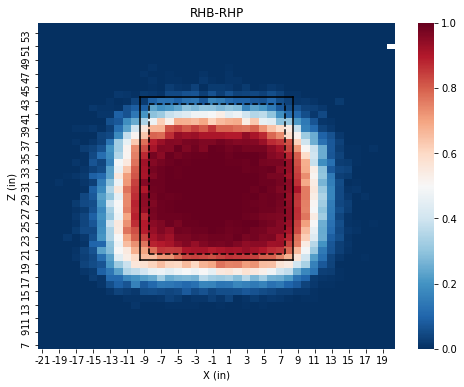

In [4]:
# function to plot called strike 
def strike_prob_plot(pitch_side='R', bat_side='R'):
    
    # specify the handedness of pitcher and batter
    batR_pitchR_df = taken_pitches_2015_17_df[(taken_pitches_2015_17_df['p_throws'] == pitch_side) &\
                                              (taken_pitches_2015_17_df['stand'] == bat_side)]

    # just keep pitch outcome and plate position
    cols_to_keep = ['description', 'plate_x', 'plate_z']
    heat_map_df = batR_pitchR_df[cols_to_keep]

    # convert to inches
    heat_map_df['plate_x'] = heat_map_df['plate_x'].apply(lambda x: x * 12)
    heat_map_df['plate_z'] = heat_map_df['plate_z'].apply(lambda x: x * 12)

    # convert outcome to binary (1 = called strike, 0 = ball)
    heat_map_df['description'] = heat_map_df['description'].apply(lambda x: 1 if x == 'called_strike' else 0)

    # set limits
    heat_map_df = heat_map_df[(np.abs(heat_map_df['plate_x']) <= 22) &\
                              (heat_map_df['plate_z'] <= 55) & (heat_map_df['plate_z'] >= 6)]

    # for binning purposes, take the "floor" of x and z coordiates
    heat_map_df['plate_x'] = np.floor(heat_map_df['plate_x']).astype(int)
    heat_map_df['plate_z'] = np.floor(heat_map_df['plate_z']).astype(int)

    # compute the historical strike probability (i.e., the mean) for each cell
    temp_df = pd.DataFrame(heat_map_df.groupby(['plate_x', 'plate_z'])['description'].mean())
    temp_df.reset_index(inplace=True, drop=False)
    temp_df.columns = ['x', 'z', 'probability']

    temp_df = temp_df.pivot('z', 'x', 'probability')
    plt.figure(figsize=(8,6))
    plt.plot([13, 29], [36, 36], '--k')
    plt.plot([13, 29], [14, 14], '--k')
    plt.plot([13, 13], [14, 36], '--k')
    plt.plot([29, 29], [14, 36], '--k')
    plt.plot([12, 30], [37, 37], '-k')
    plt.plot([12, 30], [13, 13], '-k')
    plt.plot([12, 12], [13, 37], '-k')
    plt.plot([30, 30], [13, 37], '-k')
    sns.heatmap(temp_df, cmap="RdBu_r")

    plt.ylim(reversed(plt.ylim()))
    plt.xlabel("X (in)")
    plt.ylabel("Z (in)")
    plt.title(f"{pitch_side}HB-{bat_side}HP")
    
# make the plots
strike_prob_plot(pitch_side='R', bat_side='R')
# strike_prob_plot(pitch_side='L', bat_side='L')
# strike_prob_plot(pitch_side='R', bat_side='L')
# strike_prob_plot(pitch_side='L', bat_side='R')
plt.show()

### Fitting a Generalized Additive Model for Pitch Location

We use the aggregated data from 2015-2017 to train fit the function $f^u(x, z)$ and apply the function to the data from 2018. 

In [5]:
# keep only the columns we need
cols_to_keep = ['description', 'plate_x', 'plate_z', 'p_throws', 'stand']
pitch_loc_df = taken_pitches_2015_17_df[cols_to_keep]
pitch_loc_df.columns = ['is_strike', 'x', 'z', 'pitch_side', 'bat_side']

# convert outcome to a boolean
pitch_loc_df['is_strike'] = pitch_loc_df['is_strike'].apply(lambda x: 1 if x == 'called_strike' else 0)

pitch_loc_df.head()

,is_strike,x,z,pitch_side,bat_side
0,1,0.442,3.496,R,R
1,1,0.516,3.195,R,R
2,0,-1.531,3.027,R,R
3,1,-0.258,3.106,R,R
4,0,-1.449,3.268,R,R


#### Fit the hGAM's 

In [6]:
def train_model(pitch_side='R', bat_side='R'):

    temp_df = pitch_loc_df[(pitch_loc_df['pitch_side'] == pitch_side) & (pitch_loc_df['bat_side'] == bat_side)]

    # split data into features and targets
    X_train = temp_df.drop(['is_strike', 'pitch_side', 'bat_side'], axis=1)
    y_train = temp_df['is_strike']

    # fit the "off-the-shelf" model
    gam = LogisticGAM().fit(X_train, y_train)
    
    print()
    print()
    print("==========================================")
    print(f"Summary for {bat_side}HB-{pitch_side}HP Model")
    print("==========================================")
    print()
    
    # print the summary of the model fit
    print(gam.summary())
    print()

    # print the accuracy on the training data
    print(f"{bat_side}HB-{pitch_side}HP Model accuracy: {round(gam.accuracy(X_train, y_train), 3)}")
    print()
    
    print("==========================================")
    print("==========================================")
    print()

    return gam

RHB_RHP_gam = train_model(pitch_side='R', bat_side='R')
LHB_LHP_gam = train_model(pitch_side='L', bat_side='L')
RHB_LHP_gam = train_model(pitch_side='L', bat_side='R')
LHB_RHP_gam = train_model(pitch_side='R', bat_side='L')



Summary for RHB-RHP Model

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     25.0451
Link Function:                        LogitLink Log Likelihood:                                -79856.9135
Number of Samples:                       367551 AIC:                                           159763.9173
                                                AICc:                                          159763.9211
                                                UBRE:                                               2.4347
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.6755
Feature 

#### use a Kernel Density Plot to test the model on 2018 data

In [7]:
# get the 2018 data
taken_pitches_2018_df = get_pitch_data(2018)

# keep only the columns we need
cols_to_keep = ['plate_x', 'plate_z', 'p_throws', 'stand']
pitch_loc_2018_df = taken_pitches_2018_df[cols_to_keep]
pitch_loc_2018_df.columns = ['x', 'z', 'pitch_side', 'bat_side']

pitch_loc_2018_df.head()

Gathering data for 2018 season

Number of total pitches in 2018 data: 721190

Number of pitches taken: 364105
Percentage of pitches taken: 50.49

Number of strikes taken: 121519
Percentage of pitches taken that were called strikes: 33.37

Top boundary of approximate strike zone: 5.03
Bottom boundary of approximate strike zone: 1.61
Right boundary of approximate strike zone: 0.71
Left boundary of approximate strike zone: -0.71

Number of pitches within 1 foot of approximate stike zone: 320855
Percentage of pitches within 1 foot of approximate strike zone: 44.49

Number of unique umpires: 89
Number of unique batters: 967
Number of unique catchers: 116
Number of unique pitchers: 796




,x,z,pitch_side,bat_side
0,-0.1730,2.4119,R,L
1,-0.4963,2.3184,R,L
2,0.1766,1.9721,R,R
3,-0.2969,4.3905,R,R
4,0.0283,3.8452,R,R


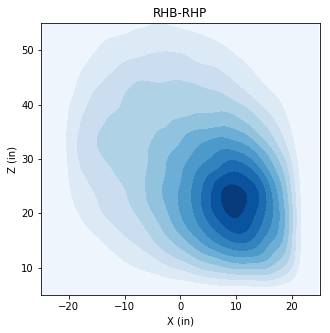

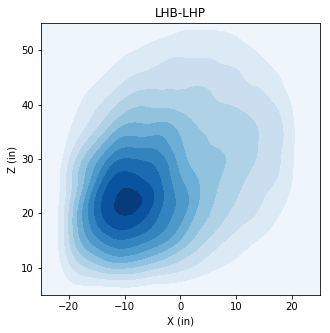

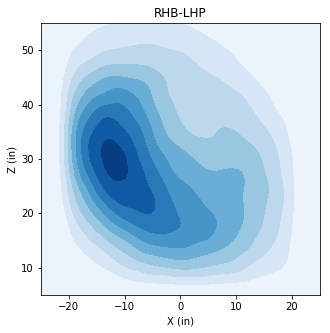

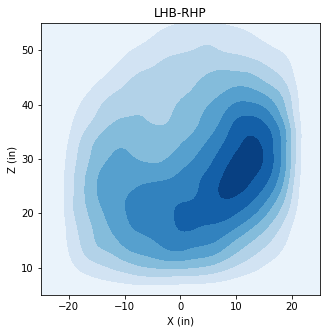

In [8]:
def pitch_location_kde_plot(df, pitch_side='R', bat_side='R'):

    temp_df = df[(df['pitch_side'] == pitch_side) & (df['bat_side'] == bat_side)]

    # keep only the model features
    x_z_df = temp_df.drop(['pitch_side', 'bat_side'], axis=1)

    # convert coordinates to feet
    x_z_df = x_z_df * 12.
    
    # convert coordinates to lists
    x = x_z_df['x'].tolist()
    z = x_z_df['z'].tolist()
    
    # plot the kernel density estimation 
    plt.figure(figsize=(5,5))
    sns.kdeplot(x, z, cmap="Blues", shade=True, shade_lowest=True, )
    plt.xlim([-25, 25])
    plt.ylim([5, 55])
    plt.xlabel("X (in)")
    plt.ylabel("Z (in)")
    plt.title(f"{pitch_side}HB-{bat_side}HP")

# make the plots
pitch_location_kde_plot(pitch_loc_2018_df, pitch_side='R', bat_side='R')
pitch_location_kde_plot(pitch_loc_2018_df, pitch_side='L', bat_side='L')
pitch_location_kde_plot(pitch_loc_2018_df, pitch_side='R', bat_side='L')
pitch_location_kde_plot(pitch_loc_2018_df, pitch_side='L', bat_side='R')
plt.show()